# Feature Engineering

Here, I'll explore some strategies for engineering features. This includes:

* Dealing with categorical variables
* Dealing with colinearity

I haven't figured out what to do yet; stay tuned!

In [34]:
# Import some useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Import various things from sklearn
from sklearn.model_selection import cross_val_score

## Dealing with Counts

Oftentimes raw numbers or counts aren't useful, maybe because:

* Long tail; most counts are low, but a few might be really high
* Other??

Here's bits on how to deal with them; first I'll load the data (Online Popularity data) and inspect the counts

In [4]:
# Load and print info on online popularity
onlineRaw = pd.read_csv("./OnlineNewsPopularity.csv", 
                        delimiter = ', ', # Get rid of leading spaces
                        engine = 'python') # Avoid a warning
onlineRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
url                              39644 non-null object
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null floa

We'll at least start with the number of words, here called `n_tokens_content` :

In [5]:
onlineRaw['n_tokens_content'].describe()

count    39644.000000
mean       546.514731
std        471.107508
min          0.000000
25%        246.000000
50%        409.000000
75%        716.000000
max       8474.000000
Name: n_tokens_content, dtype: float64

Also can plot it to see how it bins:

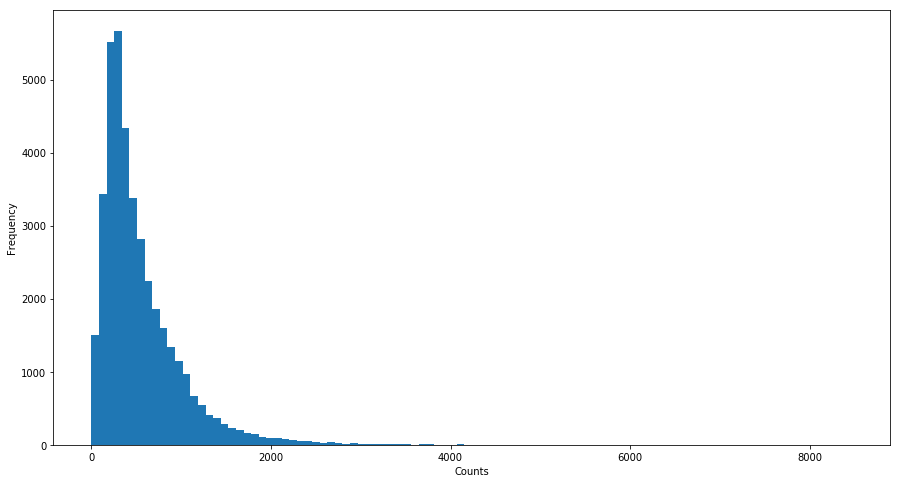

In [11]:
plt.figure(figsize = (15,8))
plt.hist(onlineRaw['n_tokens_content'], bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Counts')
plt.show()

As shown, the distribution has a big long tail on the right. We're going to look at some ways to address that

### Binarization

This means taking the counts and just making it a logical feature. I take this to mean one of two things:

1. Turn any count into "1"; works really well when all you care about is IF something happened, so you can throw out the counts themselves and make them all 1. I think this also shows up a lot in sparse feature spaces
2. Pick some threshold; anything below that is 0, anything above is 1

In this case, we DO have some zeros; let's see what happens if we binarize on a threshold versus on non-zero

In [20]:
# Binarize on non-zero
nonZeroBin = onlineRaw['n_tokens_content'] > 0
print(nonZeroBin.value_counts())

# Binarize on over/under 1000
threshBin = onlineRaw['n_tokens_content'] > 500
print(threshBin.value_counts())

True     38463
False     1181
Name: n_tokens_content, dtype: int64
False    23514
True     16130
Name: n_tokens_content, dtype: int64


Worth noting: I could easily just throw out the "false" observations in the first case and make all the remaining things "1" if I wanted. So this is the easiest way to do it

### Quantization/Binning

These are approaches where we do a histogram-style binning on the numeric data instead. The idea here is to take the fine-grained detail and zoom out; the coarse-grained version can capture some of the meaningful differences without introducing the noise of the granularity. 

2 basic ways to do it:

1. Draw up fixed bins ahead of time and put things in those bins
2. Use the distribution itself to determine the bins using quantiles

Let's run through both methods here:

#### Fixed Bins

We COULD do a fixed width bin or variable length. An example is ages; we might do something like this:

* 0-5 yrs
* 6-18 yrs
* 19-25 yrs
* 26-35 yrs
* 36-45 yrs
* 46-55 yrs
* 56+ yrs

The idea here is that while the bins are not a standard size, the ones we chose are more representative of phases of life. We could also do a simple linear binning, where we divide up by 10 year increments. Supposing we have a whole bunch of people aged 0-99, here's how I'd do that:

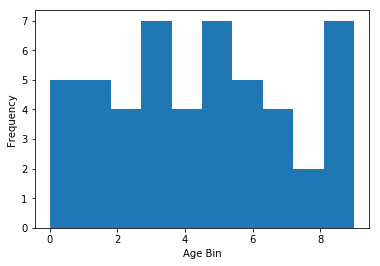

In [41]:
# Generate 50 random ages
randomAges = np.random.randint(0,100,50)

# Floor-divide everything by 10 to get the bin number (order is meaningful)
binnedAges = np.floor_divide(randomAges, 10)

# Make it a series and get the histogram
plt.hist(pd.Series(binnedAges), bins = 10)
plt.xlabel('Age Bin')
plt.ylabel('Frequency')
plt.show()

We can also do fixed bins that climb logarithmically; this is more useful here, where my counts climb in a non-linear way. 

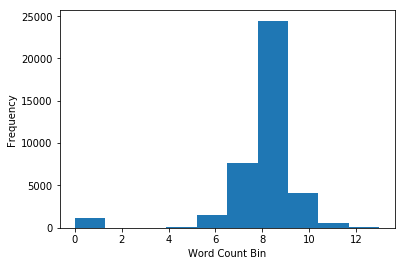

In [40]:
# Create logarithmic bins for my word counts
onlineLogBins = np.floor(np.log2(onlineRaw['n_tokens_content'] + 1))

# Create a histogram showing the bins
plt.hist(onlineLogBins)
plt.xlabel('Word Count Bin')
plt.ylabel('Frequency')
plt.show()

The log binning is related to the log transform, which I'll come back to. But it's easy to see here that it looks WAY different that before; much easier to see the full range of data. 

#### Using Quantiles

Rather than fixing the bins, either by regular intervals or manual ones, we can also use the data themselves, pulling out the quantiles to use for bin edges. The result will be a pretty uniform distribution of course (10% of data lie below the 10% quantiles, 10% between 10% and 20% quantile, etc.), but it helps to deal with massive outliers. 

Here's how to do that on the online popularity data:

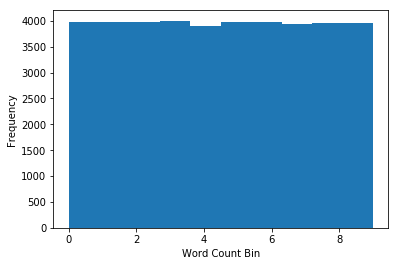

In [39]:
# Create 10 bins to hold things
onlineQuantBins = pd.qcut(onlineRaw['n_tokens_content'], 10, labels = False)

# Check out the resulting binning
plt.hist(onlineQuantBins)
plt.xlabel('Word Count Bin')
plt.ylabel('Frequency')
plt.show()

As expected, it's basically a uniform distribution

### Log Transforms

Taking logs de-emphasizes the high extremes of data; the differences between high counts are compressed, while the differences between low counts are not. In fact, between 0 and 1, the counts are elongated; because of this (and because log(0) is undefined), counts data is usually logged with 1 added

Here's how to do it on the online data:

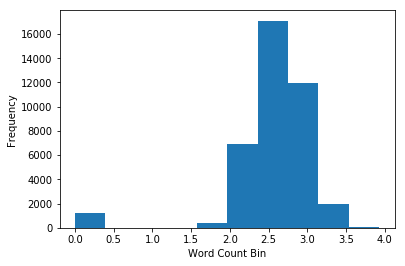

In [38]:
onlineLogTrans = np.log10(onlineRaw['n_tokens_content'] + 1)

plt.hist(onlineLogTrans)
plt.xlabel('Word Count Bin')
plt.ylabel('Frequency')
plt.show()

This histogram looks really similar to the previous one, but importantly, the values are continuous here. So we still have the granularity, but we've compressed the high extreme values. 

### Box-CoxPower Transforms

Basically the same as log transforms, but generalized. Method is something like this:

* Specify a parameter lambda
* If lambda == 0, take ln(x)
* Otherwise, raise x^lambda and do a scaling as well

This means that lambda < 1 compresses higher values, while lambda > 1 expands them

*How do we choose lambda??* 

Luckily, we don't have to; you can automatically use methods that choose the Box-Cox that gets your data closest to normal. It's build into Python as shown here:
    

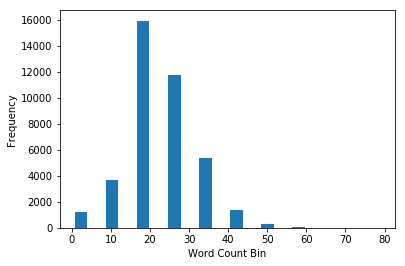

In [37]:
# Get the best transform
onlineBoxCox = stats.boxcox(onlineRaw['n_tokens_content'] + 1)

# Plot it
plt.hist(onlineBoxCox)
plt.xlabel('Word Count Bin')
plt.ylabel('Frequency')
plt.show()

Notably, specifying `lmbda = 0` in the Box-Cox is how we do the log one (or how we specify a certain lambda).

### Checking Normality

Useful tool for this is the probplot from the `scipy.stats` submodule:

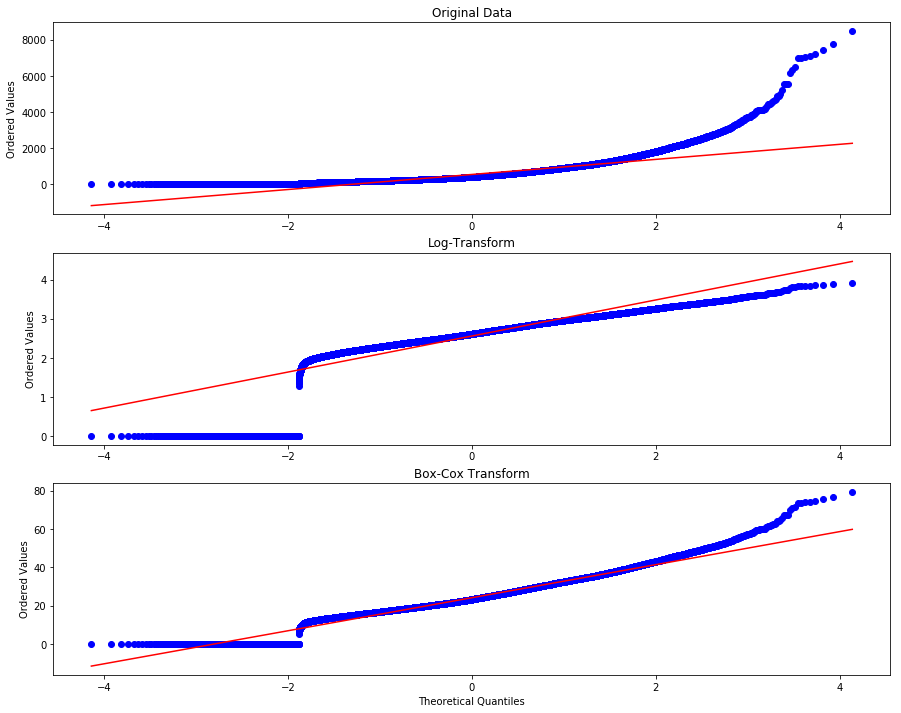

In [49]:
# Make 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,12))

# Plot all 3
stats.probplot(onlineRaw['n_tokens_content'], dist = stats.norm, plot = ax1)
stats.probplot(onlineLogTrans, dist = stats.norm, plot = ax2)
stats.probplot(onlineBoxCox[0], dist = stats.norm, plot = ax3)

# Set all the labels on x such that only the bottom one appears
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('Theoretical Quantiles')

# Set all the titles
ax1.set_title('Original Data')
ax2.set_title('Log-Transform')
ax3.set_title('Box-Cox Transform')

plt.show()

We don't expect it to match at the left end, because data is non-zero (unlike Gaussian); but we see that at right end, the transforms help conform the extreme high values to more normal ones

## Feature Scaling and Normalization

3 basic methods here:

1. Min-Max Scaling
2. Standardization (Z-scores)
3. l^2 normalization

Short blurb/demo on each:

### Min-Max Scaling

Basically, just scaling between the min and max of data so everything is between 0 and 1 now:

### Standardization

Subtract the mean and scale by standard deviation, giving up Z-scores (mean of 0, std of 1)

### L^2 Normalization

The basic idea here is, for a feature, you scale it down so the entire magnitude is 1; this means you'll inherently be putting things on the same scale, where every vector has magnitude of 1. 

Why do any of this? Apparently it helps with the numeric stability of the underlying algorithms that do model/parameter optimization. It also can help understanding the variation for us humans (at least that's what I think).

Worth noting: unlike the transforms, it doesn't change the shape of the data, just the scale. 

## Interaction Features

Easy to introduce, but they scale VERY quickly, so be careful. Here's how to do it: